<a href="https://colab.research.google.com/github/dhasaf/Classification/blob/main/FlightPricePrediction1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flight price prediction**
### Our goal is to build supervised Natural Language Processing (NLP) machine learning models to predict the price of a flight.

### **Import Libaries**

In [377]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import os
import tarfile
import urllib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

### **Load the data**

In [378]:
flight = pd.read_csv("Flight_price.csv")
flight.head()

,number,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Take a 100,000 sample

In [379]:
flight = flight.sample(n=1000, random_state=42)

### **View data**

In [380]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 27131 to 75274
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            1000 non-null   int64  
 1   airline           1000 non-null   object 
 2   flight            1000 non-null   object 
 3   source_city       1000 non-null   object 
 4   departure_time    1000 non-null   object 
 5   stops             1000 non-null   object 
 6   arrival_time      1000 non-null   object 
 7   destination_city  1000 non-null   object 
 8   class             1000 non-null   object 
 9   duration          1000 non-null   float64
 10  lead_reservation  1000 non-null   int64  
 11  price             1000 non-null   int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 101.6+ KB


In [381]:
flight.describe()

,number,duration,lead_reservation,price
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,144905.771000,12.169290,25.882000,20020.685000
std,87018.045615,7.172312,13.599302,22496.083452
min,49.000000,1.080000,1.000000,1105.000000
25%,69877.000000,6.670000,14.000000,4823.750000
50%,143671.000000,11.250000,25.000000,7021.000000
75%,218396.750000,16.020000,38.000000,41269.000000
max,300089.000000,36.830000,49.000000,98839.000000


In [382]:
flight.shape

(1000, 12)

**Check number of null values**

In [383]:
flight.isnull().sum()

number              0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
lead_reservation    0
price               0
dtype: int64

Check duplicates 

In [384]:
flight.duplicated().sum()

0

number of unique data for each feature

In [385]:
flight.nunique()

number              1000
airline                6
flight               449
source_city            6
departure_time         6
stops                  3
arrival_time           6
destination_city       6
class                  2
duration             290
lead_reservation      49
price                662
dtype: int64

As we understand from the result above, the "number" column is an index since its unique values are just like the size of our dataset, which is 300153.
So, it will be dropped from our dataset.

In [386]:
flight.drop(["number"], axis=1, inplace=True)

In [387]:
flight.drop(["flight"], axis=1, inplace=True)

In [388]:
flight.shape

(1000, 10)

convert price from int to float

In [389]:
flight['price'] = flight['price'].astype(float)

**Draw histogram to view the numeric values distribution**

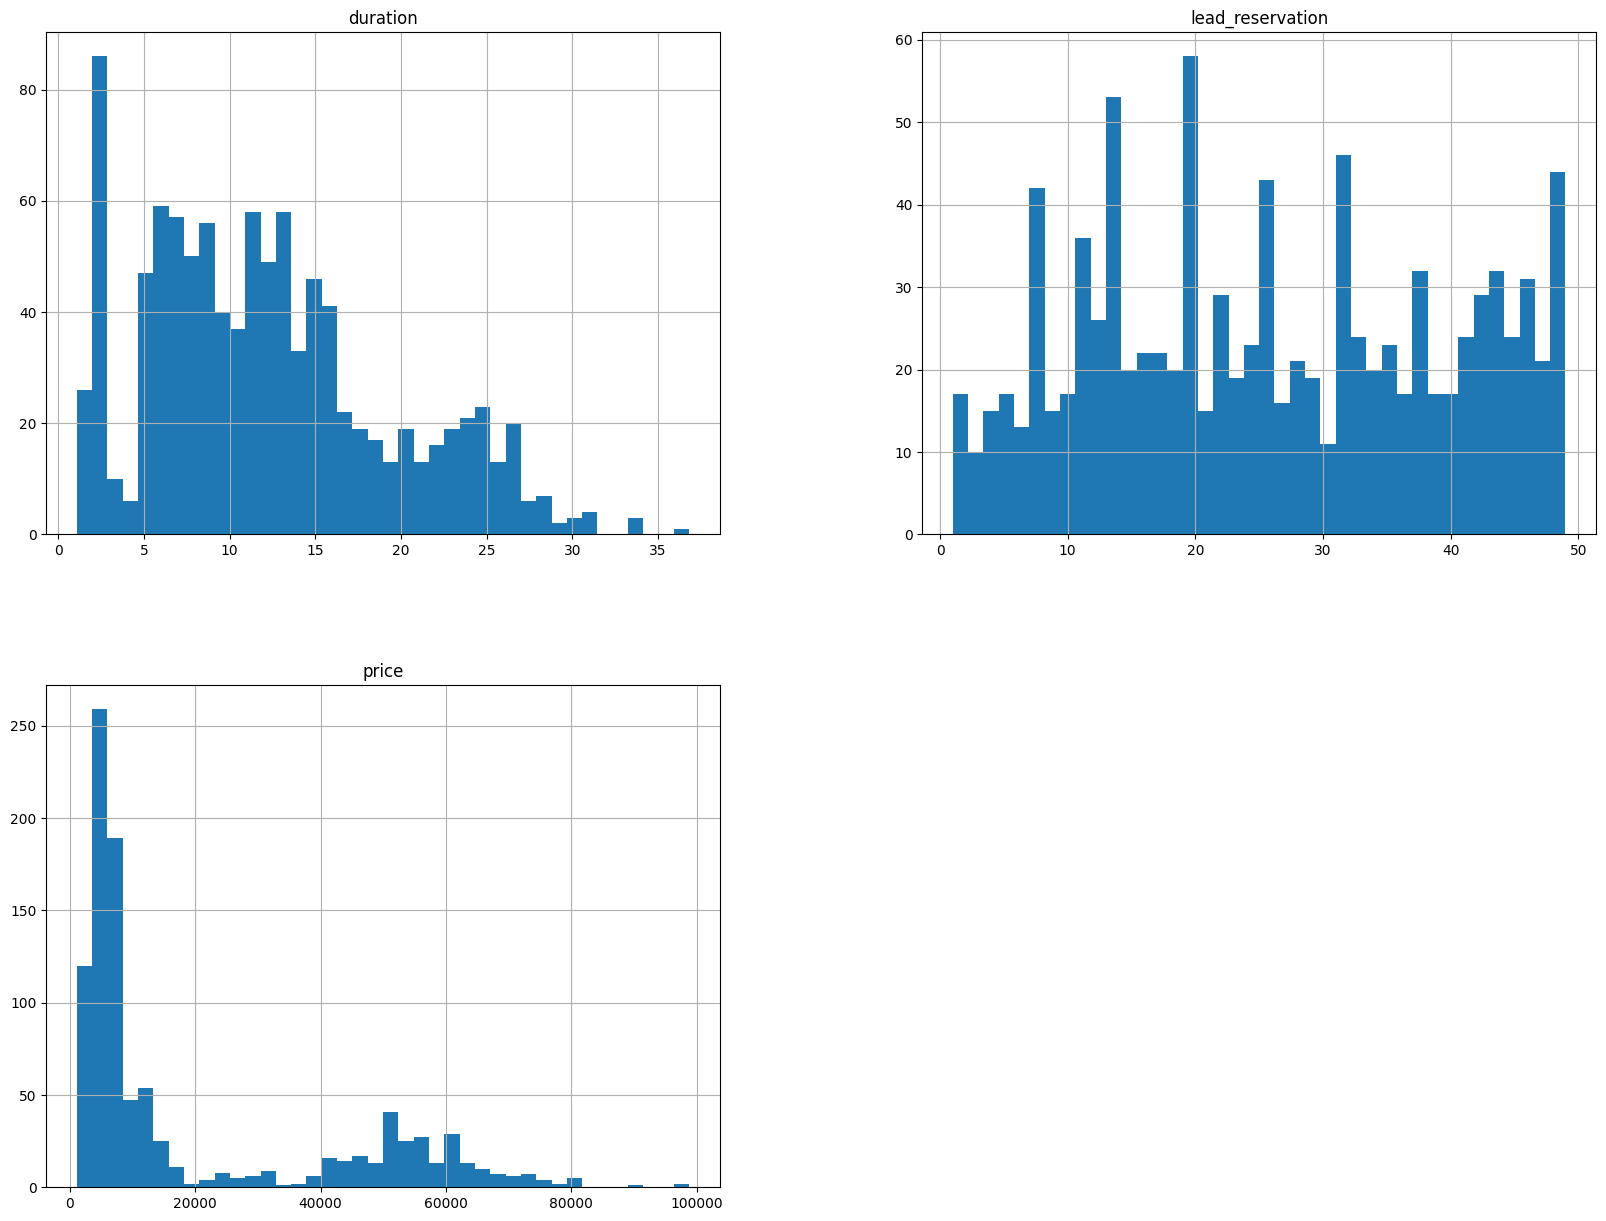

In [390]:
%matplotlib inline
import matplotlib.pyplot as plt
flight.hist(bins=40, figsize=(20,15))
plt.show()

**Detect and Remove outliers** 

<Axes: xlabel='lead_reservation'>

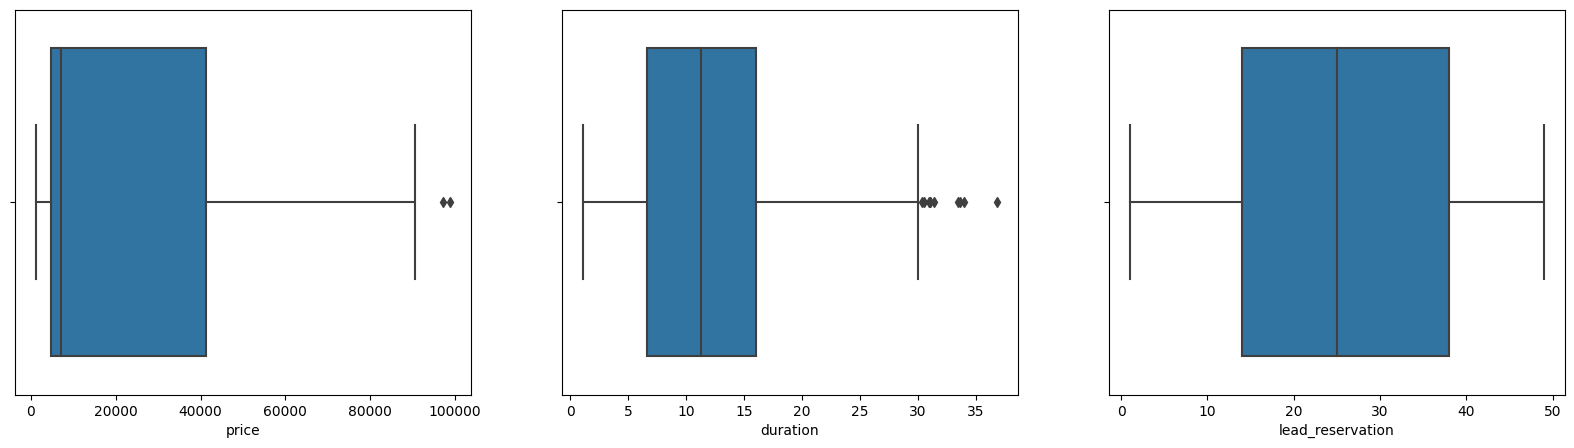

In [391]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['duration'], ax=axs[1])
sns.boxplot(x=flight['lead_reservation'], ax=axs[2])

In [392]:
Q1 = flight.quantile(0.25)
Q3 = flight.quantile(0.75)
IQR = Q3 - Q1
flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]

<ipython-input-392-63ea7a9fe649>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]


<Axes: xlabel='lead_reservation'>

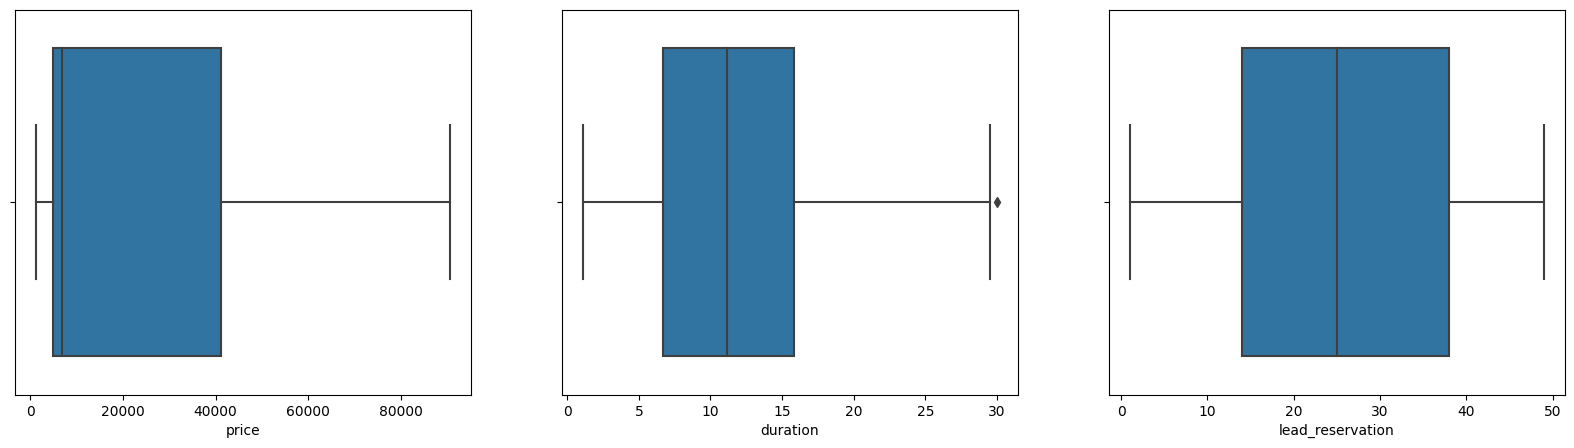

In [393]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['duration'], ax=axs[1])
sns.boxplot(x=flight['lead_reservation'], ax=axs[2])

we will use the StratifiedShuffleSplit to split the data keeping the same distribution of class category.

In [394]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 27131 to 75274
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           988 non-null    object 
 1   source_city       988 non-null    object 
 2   departure_time    988 non-null    object 
 3   stops             988 non-null    object 
 4   arrival_time      988 non-null    object 
 5   destination_city  988 non-null    object 
 6   class             988 non-null    object 
 7   duration          988 non-null    float64
 8   lead_reservation  988 non-null    int64  
 9   price             988 non-null    float64
dtypes: float64(2), int64(1), object(7)
memory usage: 84.9+ KB


In [395]:
from sklearn.preprocessing import OneHotEncoder
# Select all categorical columns in the dataset
cat_cols = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

# Create an instance of the OneHotEncoder class
encoder = OneHotEncoder()

# Fit the encoder to the categorical data and transform it
cat_encoded = encoder.fit_transform(flight[cat_cols])


# Convert the encoded data to a pandas DataFrame with meaningful column names
cat_encoded_df = pd.DataFrame(cat_encoded.toarray(), columns=[f"{col}_{val}" for col in cat_cols for val in encoder.categories_[cat_cols.index(col)]])

# Add the encoded features to the original dataset
flight = pd.concat(cat_encoded_df, axis=1)

# Drop the original categorical columns from the dataset
flight = flight.drop(cat_cols, axis=1)

TypeError: ignored

In [300]:
flight["lead_reservation"].value_counts

<bound method IndexOpsMixin.value_counts of 27131     40.0
266857    42.0
141228    41.0
288329    14.0
97334     20.0
          ... 
983        NaN
984        NaN
985        NaN
986        NaN
987        NaN
Name: lead_reservation, Length: 1973, dtype: float64>

In [250]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1973 entries, 27131 to 987
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   duration                      988 non-null    float64
 1   lead_reservation              988 non-null    float64
 2   price                         988 non-null    float64
 3   airline_AirAsia               988 non-null    float64
 4   airline_Air_India             988 non-null    float64
 5   airline_GO_FIRST              988 non-null    float64
 6   airline_Indigo                988 non-null    float64
 7   airline_SpiceJet              988 non-null    float64
 8   airline_Vistara               988 non-null    float64
 9   source_city_Bangalore         988 non-null    float64
 10  source_city_Chennai           988 non-null    float64
 11  source_city_Delhi             988 non-null    float64
 12  source_city_Hyderabad         988 non-null    float64
 13  

<Axes: >

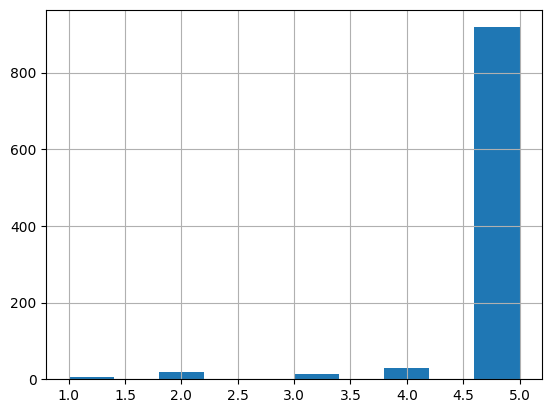

In [258]:
flight["lead_reservation_cat"] = pd.cut(flight["lead_reservation"], bins = [], labels = [1,2,3,4,5])
flight["lead_reservation_cat"].hist()

### **Get the size of taining set and test set**

In [ ]:
#using Scikit-Learn train_test_split()
train_set, test_set = train_test_split(flight, test_size=0.2, random_state=42)
print("size of training data",len(train_set))
print("size of testing data",len(test_set))

In [ ]:
#Split the dataset into training and testing sets using StratifiedShuffleSplit based on the Class column
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(flight, flight["class"]):
    strat_train_set = flight.loc[train_index]
    strat_test_set = flight.loc[test_index]

In [ ]:
#strat_test_set["class1"].value_counts()/ len(strat_test_set)

In [ ]:
#strat_train_set["class1"].value_counts()/ len(strat_train_set)

In [ ]:
##flight["class1"].value_counts()/ len(data)

In [ ]:
##for set_ in (strat_train_set, strat_test_set):
  ##set_.drop("class1", axis=1, inplace=True)

In [ ]:
##strat_train_set.info()

**Correlation matrix**

In [251]:
##flight = strat_train_set.copy()
corr_matrix= flight.corr()
corr_matrix["price"].sort_values(ascending=False)

price                           1.000000
airline_AirAsia                 1.000000
departure_time_Night            1.000000
arrival_time_Afternoon          1.000000
destination_city_Bangalore      1.000000
source_city_Kolkata             0.500215
class_Economy                   0.500215
duration                        0.295674
lead_reservation               -0.070553
departure_time_Morning         -0.499785
source_city_Chennai            -0.500215
departure_time_Evening         -0.500215
class_Business                 -0.500215
airline_Vistara                -1.000000
arrival_time_Evening           -1.000000
destination_city_Hyderabad     -1.000000
airline_Air_India                    NaN
airline_GO_FIRST                     NaN
airline_Indigo                       NaN
airline_SpiceJet                     NaN
source_city_Bangalore                NaN
source_city_Delhi                    NaN
source_city_Hyderabad                NaN
source_city_Mumbai                   NaN
departure_time_A

In [252]:
corr_matrix

,duration,lead_reservation,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,...,arrival_time_Morning,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy
duration,1.000000,-0.013219,0.295674,0.999932,NaN,NaN,NaN,NaN,-0.999932,NaN,...,NaN,NaN,0.999932,NaN,NaN,-0.999932,NaN,NaN,-0.489900,0.489900
lead_reservation,-0.013219,1.000000,-0.070553,-0.944911,NaN,NaN,NaN,NaN,0.944911,NaN,...,NaN,NaN,-0.944911,NaN,NaN,0.944911,NaN,NaN,0.755929,-0.755929
price,0.295674,-0.070553,1.000000,1.000000,NaN,NaN,NaN,NaN,-1.000000,NaN,...,NaN,NaN,1.000000,NaN,NaN,-1.000000,NaN,NaN,-0.500215,0.500215
airline_AirAsia,0.999932,-0.944911,1.000000,1.000000,-0.157389,-0.074448,-0.110064,-0.049735,-0.230545,0.088591,...,0.027318,-0.035620,0.006914,-0.034261,0.023763,-0.046044,0.085222,-0.035725,-0.171614,0.171614
airline_Air_India,NaN,NaN,NaN,-0.157389,1.000000,-0.163687,-0.241996,-0.109351,-0.506895,-0.018126,...,0.040780,0.004404,-0.041139,-0.014876,-0.025706,0.007596,-0.018137,0.084901,0.132295,-0.132295
airline_GO_FIRST,NaN,NaN,NaN,-0.074448,-0.163687,1.000000,-0.114468,-0.051725,-0.239770,-0.007535,...,-0.041044,0.046376,-0.023016,-0.063816,0.024093,-0.009271,-0.001494,0.062194,-0.178481,0.178481
airline_Indigo,NaN,NaN,NaN,-0.110064,-0.241996,-0.114468,1.000000,-0.076471,-0.354478,0.003161,...,-0.089745,0.003622,-0.035101,0.099035,-0.033635,0.033136,0.012385,-0.059677,-0.263868,0.263868
airline_SpiceJet,NaN,NaN,NaN,-0.049735,-0.109351,-0.051725,-0.076471,1.000000,-0.160179,0.008433,...,0.012131,-0.024748,-0.039970,-0.023804,0.045954,-0.078955,0.043722,0.044887,-0.119235,0.119235
airline_Vistara,-0.999932,0.944911,-1.000000,-0.230545,-0.506895,-0.239770,-0.354478,-0.160179,1.000000,-0.030090,...,0.031047,-0.003712,0.084383,0.001960,0.005371,0.026489,-0.050918,-0.063327,0.294005,-0.294005
source_city_Bangalore,NaN,NaN,NaN,0.088591,-0.018126,-0.007535,0.003161,0.008433,-0.030090,1.000000,...,-0.067245,-0.008860,-0.202635,-0.039487,0.085263,-0.022068,0.040700,0.124922,0.002915,-0.002915


In [ ]:
print(flight["stops"].isnull().sum())

In [ ]:
from pandas.plotting import scatter_matrix
attributes=["duration","class","lead_reservation","price"]
scatter_matrix(flight[attributes], figsize=(12,8))

In [ ]:
flight['stops'].value_counts()

### **Random Forest**

In [ ]:
flightX = train_set.drop("price", axis =1)
flightX = train_set["price"].copy()
X_train, X_test, y_train, y_test = train_test_split(flightX, flightX, test_size=0.2, random_state=42)